In [ ]:
# Execute this cell to get the notebook style adjusted:
# from IPython.core.display import HTML
# HTML(open('nb_style.css', "r").read())

# Introduction

This exercise provides an example how the range-compression (range-focusing) of a radar system works. Another keyword for the method is ”matched pulse” filtering. (Frequency- step radars and frequency-modulated continous wave (FMCW) radars use a different approach.)

In [1]:
# Import necessary package here.
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# Configure plot universal property
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['font.size'] = 16

%matplotlib inline

## 1.  [Chirped Pulse](https://en.wikipedia.org/wiki/Chirp)  and matched filter

A chirped puls $s(t)$ has a form:

$$
s(t) =\begin{cases}
\begin{aligned}
&\exp{(it\cdot[\omega_0+\pi\beta_c t])} \ \ &|t| < \frac{\tau_p}{2}  \\
&0 & else
\end{aligned}
\end{cases}
$$

The pulse envelope is rectangular, which is also called **box-car**, where:

1. $\omega_0=2\pi f_0$ is the central freuency $[s^{-1}]$, 
2. $\tau_p$ is the pulse length $[s]$ and 
3. $\beta_c$ is the requency change rate $[Hz/s]$. 
4. The bandwidth of the pulse is given by $f_{bw} = \beta_c\cdot \tau_p [Hz]$.

**Matched Filter**

The matched filter function is defined as $h(t)=s^*(-t)$.

$$
h(t)=s^*(-t) = \begin{cases}
\begin{aligned}
&\exp{(it\cdot[\omega_0 - \pi\beta_c t])} \ \ &|t| < \frac{\tau_p}{2}  \\
&0 & else
\end{aligned}
\end{cases}
$$

<div class="alert alert-info">
Task: Creat a chirped pulse in time and frequency domain and a matched filter
</div>

In [2]:
def chirped_pulse(t, omega, beta, tau):
    
    x = (omega + np.pi*beta*t)*t
    s = np.exp(1j * x[:, np.newaxis])
    s[np.where(np.abs(t) >= tau/2)] = 0
    
    return s

In [3]:
# set time axis
t0, t1, dt = [-1e-6, 1e-6, 3e-10]

# define pulse parameters
f0, bw, tau  = [20e6, 20e6, 1.5e-6]

bc = bw / tau
w0 = 2 * np.pi * f0

# set freq. axis
fmin, fmax, fphi = [0, 45e6, -20e6]

t = np.arange(t0, t1, dt)
N = t.shape[0]
N2 = round(N/2)

# f = np.arange(-1/(2*dt), 1/(2*dt), 1/(dt*N))
# frange = np.where((f>fmin)&(f<fmax))
# frange_phi = np.where((f>fphi)&(f<fmax))

In [4]:
s = chirped_pulse(t, w0, bc, tau)
s_fft = fft(s[np.where(s!=0)], n=N) * N

h = np.conj(np.flip(s))
h_fft = fft(h[np.where(h!=0)], n=N) * N

f = fftfreq(s_fft.size, d = dt)
frange = np.where((f>fmin)&(f<fmax))
fphi_range = np.where((f>fphi)&(f<fmax))

<div class="alert alert-info">
Task: Plot the signal and matched filter in time and frequency domain.
</div>

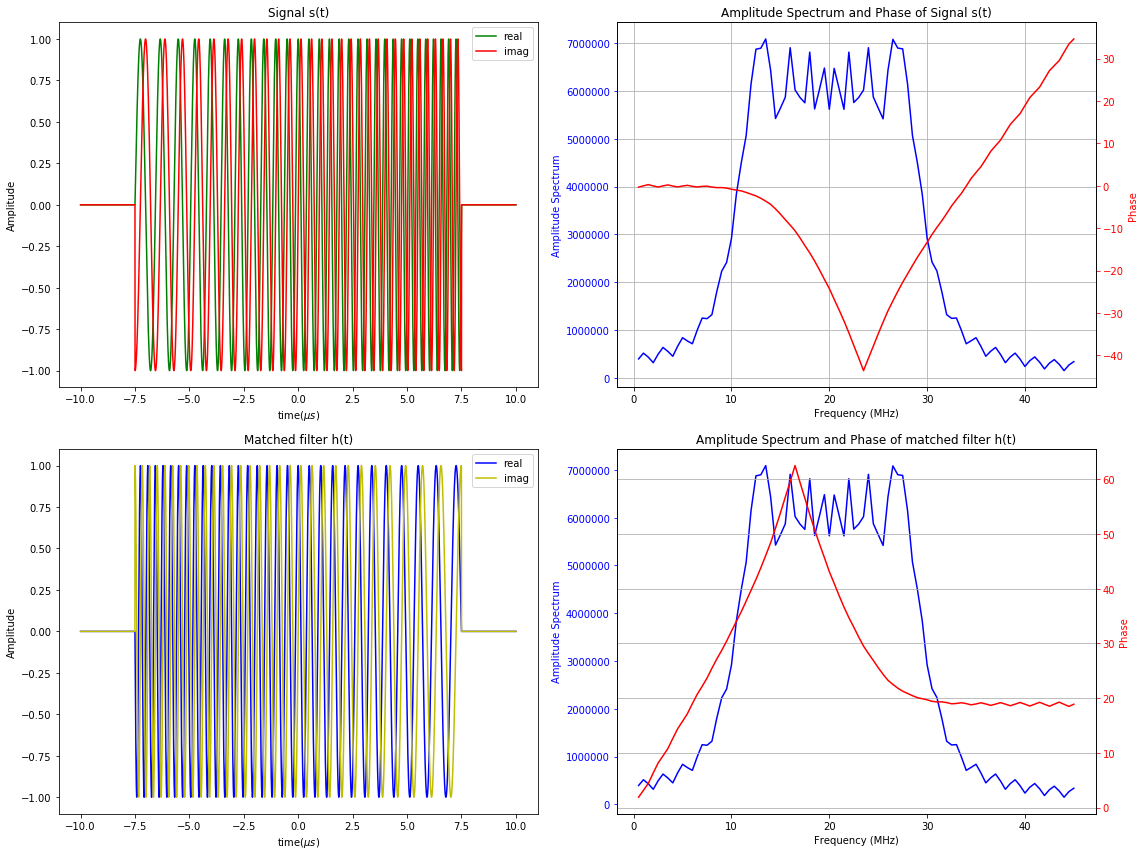

In [18]:
fig = plt.figure(figsize=[16, 12])

# Plot signal in time domain
ax1 = fig.add_subplot(221)
ax1.plot(t/1e-7, np.real(s), 'g', label='real')
ax1.plot(t/1e-7, np.imag(s), 'r', label='imag')
ax1.legend(loc='upper right')
ax1.set_title('Signal s(t)')
ax1.set_xlabel('time($\mu s$)')
ax1.set_ylabel('Amplitude')
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

# Plot signal in frequency domain
ax2 = fig.add_subplot(222)
ax2.plot(f[frange]/1e6, np.abs(s_fft)[frange], 'b', label='intensity')
ax2.set_title('Amplitude Spectrum and Phase of Signal s(t)')
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Amplitude Spectrum', color='b')
ax2.tick_params('y', colors='b')

ax2_2 = ax2.twinx()
ax2_2.plot(f[frange]/1e6, np.unwrap(np.angle(s_fft))[frange], 'r', label='phase')
ax2_2.set_ylabel('Phase', color='r')
ax2_2.tick_params('y', colors='r')
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))
ax2.grid()

ax3 = fig.add_subplot(223)
ax3.plot(t/1e-7, np.real(h), 'b', label='real')
ax3.plot(t/1e-7, np.imag(h), 'y', label='imag')
ax3.legend(loc='upper right')
ax3.set_title('Matched filter h(t)')
ax3.set_xlabel('time($\mu s$)')
ax3.set_ylabel('Amplitude')
ax3.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

ax4 = fig.add_subplot(224)

# ax4.plot(freq_h[f_filter], np.abs(m_filter_f)[f_filter], 'b')
ax4.plot(f[frange]/1e6, np.abs(h_fft)[frange], 'b', label='intensity')
ax4.set_title('Amplitude Spectrum and Phase of matched filter h(t)')
ax4.set_xlabel('Frequency (MHz)')
ax4.set_ylabel('Amplitude Spectrum', color='b')
ax4.tick_params('y', colors='b')

ax4_2 = ax4.twinx()
ax4_2.plot(f[frange]/1e6, np.unwrap(np.angle(h_fft))[frange], 'r', label='imag')
ax4_2.set_ylabel('Phase', color='r')
ax4_2.tick_params('y', colors='r')
ax4_2.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))
ax4_2.grid()

# Layout
plt.tight_layout()

**Compress pulse**

Compress the pulse in time/frequency domain by a convolution with the filter function $h(t)$ and plot it. 

- Time Domain

In principle you calculate the autocorrelation function $g_1(\tau)$ of the pulse with itself:

$$
g_1(\tau) = \int_{-\infty}^{+\infty} s^*(t)s(t+\tau)dt = \int s(t')h(\tau-t')dt' = (s\ast h)(\tau)
$$

where $t'=t+\tau$.

- Frequency Domain

As the convolution is very computationally intense compress the pulse in frequency domain:

$$
g_1(\tau) = \mathcal{F}^{-1}\{ \mathcal{F} ((s*h)(\tau) )\} = \mathcal{F}^{-1}\{\tilde{s}(\omega)\cdot\tilde{h}(\omega) \}
$$

<div class="alert alert-info">
Task: Plot the compressed signal in both domain.
</div>

In [14]:
cs = np.convolve(s.flatten(), h.flatten(), 'same')
cs_fft = s_fft * h_fft

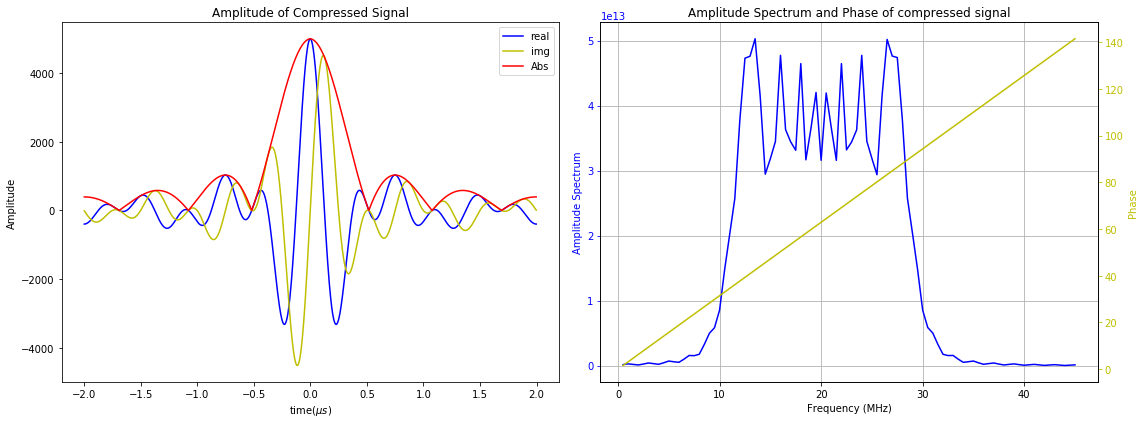

In [19]:
t_interval = [-0.2e-6, 0.2e-6]
st = np.where(t_interval[0] < t)[0].min()
sp = np.where(t_interval[1] < t)[0].min()

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.plot(t[st:sp]/1e-7, np.real(cs)[st:sp], 'b', label='real')
ax.plot(t[st:sp]/1e-7, np.imag(cs)[st:sp], 'y', label='img')
ax.plot(t[st:sp]/1e-7, np.abs(cs)[st:sp], 'r', label='Abs')

ax.set_xlabel('time($\mu s$)')
ax.set_ylabel('Amplitude')
ax.legend()
ax.set_title('Amplitude of Compressed Signal')
# ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, -4))

# Plot signal in frequency domain
ax2 = fig.add_subplot(122)
ax2.plot(f[frange]/1e6, np.abs(cs_fft)[frange], 'b')
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Amplitude Spectrum', color='b')
ax2.tick_params('y', colors='b')

ax3 = ax2.twinx()
ax3.plot(f[frange]/1e6, np.unwrap(np.angle(cs_fft)[frange]), 'y', label='imag')
ax3.set_ylabel('Phase', color='y')
ax3.tick_params('y', colors='y')
ax3.set_title('Amplitude Spectrum and Phase of compressed signal')
# ax3.set_ylim(0, 60)
# ax2.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))
ax2.grid()

# Layout
plt.tight_layout()

### 2-2. [Hamming Window](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows)

The hamming window is used to reduce side lobes.
$$
w(t) = -(\alpha -1)\cdot \cos{(\frac{2\pi t}{\tau_p})} + \alpha
$$

<div class="alert alert-info">
Task: Use a hamming window ($\alpha = 0.54$) to weighten the sharp edges of the pulse in time domain and compare the the compressed pulse (and the side-lobes) in <a href="#2-1.-Matched-Filter" class="alert-link">Section 2.1</a>
</div>

In [20]:
def hamming_window(t, alpha, tau):
    w = -(alpha - 1) * np.cos(2*np.pi*t/tau) + alpha
    w[np.where(np.abs(t) >= tau/2)] = 0
    return w

In [22]:
alp = 0.54

hw = hamming_window(t, alp, tau)
hh = h.flatten() * hw

cs_hm = np.convolve(s.flatten(), hh, 'same')
cs_hm_fft = s_fft * fft(hh[np.where(hh!=0)], n=N)

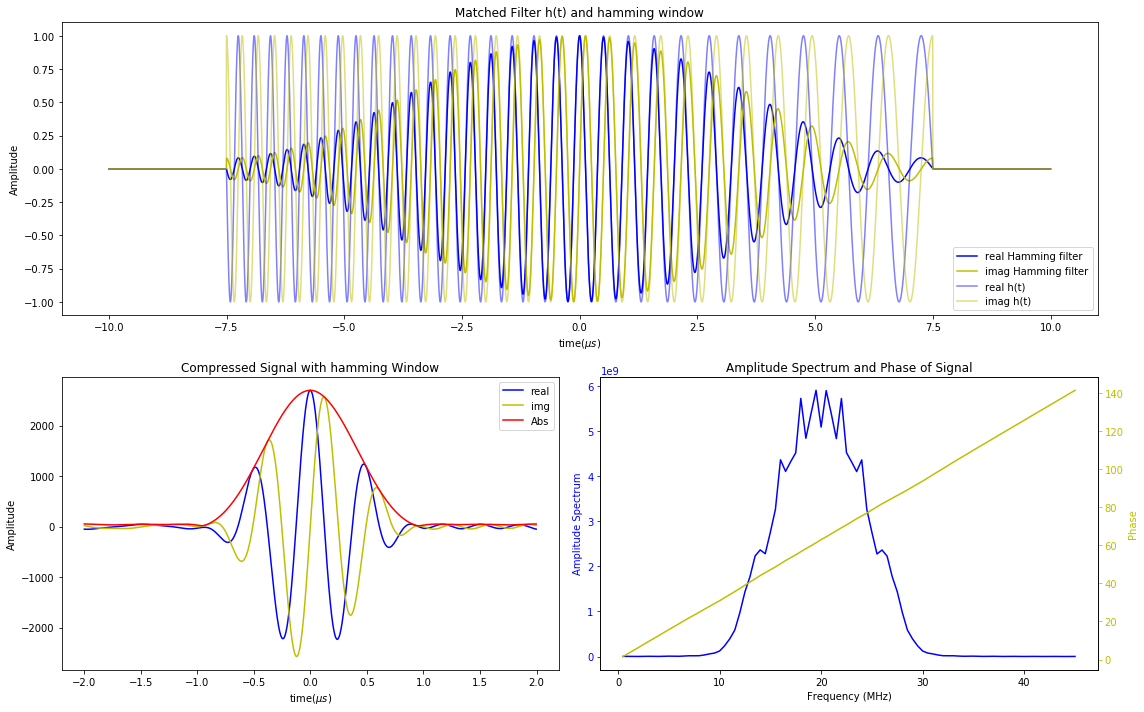

In [33]:
fig = plt.figure(figsize=(16, 10))

# # Plot signal in time domain
# ax1 = fig.add_subplot(221)
# ax1.plot(t, np.real(signal), 'g', label='real')
# ax1.plot(t, np.imag(signal), 'r', label='imag')
# ax1.plot(t, hw, 'b', label='Hamming Window')
# ax1.legend(loc='lower right')
# ax1.set_title('Amplitude of Signal s(t)')
# ax1.set_xlabel('time(s)')
# ax1.set_ylabel('Amplitude')
# ax1.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

# Plot signal in frequency domain
# ax2 = fig.add_subplot(221)
ax2 = plt.subplot2grid((2,2), (0,0), colspan=2)
ax2.plot(t/1e-7, np.real(hh), 'b', label='real Hamming filter')
ax2.plot(t/1e-7, np.imag(hh), 'y', label='imag Hamming filter')
ax2.plot(t/1e-7, np.real(h), 'b', label='real h(t)', alpha=.5)
ax2.plot(t/1e-7, np.imag(h), 'y', label='imag h(t)', alpha=.5)
ax2.legend(loc='lower right')
ax2.set_title('Matched Filter h(t) and hamming window')
ax2.set_xlabel('time($\mu s$)')
ax2.set_ylabel('Amplitude')
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))


t_interval = [-0.2e-6, 0.2e-6]
st = np.where(t_interval[0] < t)[0].min()
sp = np.where(t_interval[1] < t)[0].min()

# ax3 = fig.add_subplot(223)
ax3 = plt.subplot2grid((2,2), (1,0))
ax3.plot(t[st:sp]/1e-7, np.real(cs_hm)[st:sp], 'b', label='real')
ax3.plot(t[st:sp]/1e-7, np.imag(cs_hm)[st:sp], 'y', label='img')
ax3.plot(t[st:sp]/1e-7, np.abs(cs_hm)[st:sp], 'r', label='Abs')
# ax.ylim([-2000, 4000])
ax3.set_xlabel('time($\mu s$)')
ax3.set_ylabel('Amplitude')
ax3.legend()
ax3.set_title('Compressed Signal with hamming Window')

# Plot signal in frequency domain
# ax4 = fig.add_subplot(224)
ax4 = plt.subplot2grid((2,2), (1,1))
ax4.plot(f[frange]/1e6, np.abs(cs_hm_fft)[frange], 'b')
# ax4.plot(f[frange]/1e6, np.abs(cs_fft)[frange], 'b', alpha=.5)
ax4.set_title('Amplitude Spectrum and Phase of Signal')
ax4.set_xlabel('Frequency (MHz)')
ax4.set_ylabel('Amplitude Spectrum', color='b')
ax4.tick_params('y', colors='b')

ax44 = ax4.twinx()
ax44.plot(f[frange]/1e6, np.unwrap(np.angle(cs_hm_fft))[frange], 'y', label='imag')
ax44.set_ylabel('Phase', color='y')
ax44.tick_params('y', colors='y')


# Layout
plt.tight_layout()

# 4. Multilooking

Multilooking is basically a spatial smoothing filter which is used to reduce the effect of ”speckle” in radar images. This can be a simple spatial box-car filter, or different parts of the spectrum can be focused separately the resulting image intensities are averaged. Multilooking can also be done over a time-series of many images which can be used to enhance the resolution compared to a single radar image.

Speckle are an effect of the coherent illumination used in radar imaging. The same speckle effect appears when a laser is used to illuminate a rough surface. Incoherent light (from thermal radiation sources) does not show the effect of speckle because of the short coherence time of light. The long ”exposure” of a light-illuminated scene (Photo, Eye) of a few milliseconds average already over many many coherent representations of the extremely quickly changing speckle pattern. However, a radar uses a strictly defined pulse shape which does not changes during imaging; therefore speckle remain visible in the radar scene.

<div class="alert alert-info">
Task: Split the signal in two parts:
        $$
        \begin{aligned}
            s_1(t) &= s(t) \  \ t<0 \\
            s_2(t) &= s(t) \  \ t \geqslant 0
        \end{aligned}
        $$
compress each signal using a matched filter and average the absolute values of the signal (the intensity envelopes). Plot the absolute value of the compressed pulse.
</div>

In [ ]:
# s1 = signal[np.where(t<0)]
# s2 = signal[np.where(~(t<0))]

s1 = signal.copy()
s1[np.where(~(t<0))] = 0+0j
s2 = signal.copy()
s2[np.where(t<0)] = 0+0j

h1 = m_filter.copy()
h1[np.where(~(t<0))] = 0+0j

h2 = m_filter.copy()
h2[np.where(t<0)] = 0+0j

s1_f = fft(s1)
s1_f = np.roll(s1_f, t.shape[0])
s2_f = fft(s2)
s2_f = np.roll(s2_f, t.shape[0])
h1_f = fft(h1[np.where(h1!=0)])
h2_f = fft(h2[np.where(h2!=0)])

freq_1 = fftfreq(s1_f.size, d = dt)
freq_2 = fftfreq(s2_f.size, d = dt)

ftick_1 = np.where((freq_1>f0)&(freq_1<f1))
ftick_2 = np.where((freq_2>f0)&(freq_2<f1))

s1_compress = np.convolve(s1.flatten(), h1.flatten(), 'same')
s1_compress_f = s1_f * h1_f
s2_compress = np.convolve(s2.flatten(), h2.flatten(), 'same')
s2_compress_f = s2_f * h2_f

In [ ]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(221)

ax1.plot(t, np.real(s1), 'g', label='real s1')
ax1.plot(t, np.real(s2), 'b', label='real s2')
ax1.legend(loc='upper right')
ax1.set_title('Amplitude of signal s(t)')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('Amplitude')
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

ax2 = fig.add_subplot(222)
ax2.plot(t, np.real(h1), 'g', label='real h1')
ax2.plot(t, np.real(h2), 'b', label='real h2')
ax2.legend(loc='upper right')
ax2.set_title('Amplitude of matched filter h(t)')
ax2.set_xlabel('time(s)')
ax2.set_ylabel('Amplitude')
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-3,4))

ax3 = fig.add_subplot(223)
ax3.plot(freq_1[ftick_1], np.abs(s1_f)[ftick_1], 'b', label='s1')
ax3.plot(freq_2[ftick_2], np.abs(s2_f)[ftick_2], 'g', label='s2')
ax3.plot(freq_s[f_signal], np.abs(signal_f)[f_signal], 'r', label='s')
ax3.set_title('Amplitude Spectrum and Phase of Signals')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Amplitude Spectrum', color='b')
ax3.tick_params('y', colors='b')
ax3.legend()



ax4 = fig.add_subplot(224)
plt.tight_layout()

In [ ]:
# signal = chirped_pulse(t, omega, beta, tau)
# signal_f = fft(signal[np.where(signal!=0)])

In [ ]:
# def matched_filter(t, omega, beta, tau):
    
#     x = (omega - np.pi*beta*t)*t
#     s = np.conj(np.flip(np.exp(1j * x[:, np.newaxis])))
#     s[np.where(np.abs(t) >= tau/2)] = 0
    
#     return s

In [ ]:
# m_filter = matched_filter(t, omega, beta, tau)
# m_filter_f = fft(m_filter)
# mf = np.roll(m_filter_f, )
# freq_h = fftfreq(m_filter_f.size, d = dt)

# f_filter = np.where((freq_h>f0)&(freq_h<f1))
# f_phi_filter = np.where((freq_h>f0_phi)&(freq_h<f1))

In [ ]:
# dt = 5e-10
# t0 = -1e-6
# t1 = 1e-6
# t = np.arange(t0, t1, dt)

# freq = 20e6 # [Hz]
# bw = 20e6 # [Hz]
# tau = 1.5e-6 # [sec]

# omega = 2*np.pi*freq
# beta = bw / tau

# f0 = 0
# f1 = 40e6
# f0_phi = -20e6

# print('Central Angular Frequency is :{} Hz'.format(omega))
# print('Pulse Length is : {} s'.format(tau))
# print('Frequency change rate is: {} Hz/s'.format(beta))
# print('-'*60)
# print('Bandwidth is {} MHz'.format(beta*tau/1e6))